In [11]:
#Definizione iniziale
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import csv
from datetime import datetime, timedelta
import matplotlib.cm as cm
init_val={
    'timestamp':5,
    'numChargers' : 12,
    'v2g':False
}

def process_building_load(buildingLoadScaling):
    # Carica il file Excel
    file_path = r'Building_load.xlsx'
    df = pd.read_excel(file_path)

    # Rimuovi spazi bianchi dai valori della colonna "Time"
    df['Time'] = df['Time'].str.strip()

    # Converti la colonna "Time" in formato datetime
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

    # Imposta la colonna "Time" come indice
    df.set_index('Time', inplace=True)

    # Risample i dati ogni 5 minuti calcolando la media
    df_resampled = df.resample(str(init_val['timestamp'])+'T').mean()

    # Converti la colonna "Potenza normalizzata [W]" in un vettore np.array
    potenza_norm_array = df_resampled['Potenza normalizzata [W]'].to_numpy()

    # Calcola il vettore di potenza giornaliero scalando il profilo sul massimo dell'edificio
    potenza_build_array = potenza_norm_array * buildingLoadScaling * 0.7

    return potenza_build_array

def process_pv_production():
    # Leggi il file Excel
    file_path = r'pv_production.xlsx'
    df = pd.read_excel(file_path)

    # Assicurati che le colonne abbiano i nomi corretti
    df.columns = ['Time', 'Value']

    # Converte i dati in un np.array
    original_values = np.array(df['Value'])

    # I tuoi dati originali ogni 15 minuti
    original_time = np.arange(0, 24, 0.25)  # ad esempio da 0 a 24 ore

    # Nuovi intervalli di tempo ogni 5 minuti
    new_time = np.arange(0, 24, init_val['timestamp']/60.)  # da 0 a 24 ore, ogni 5 minuti

    # Usa numpy.interp per interpolare i nuovi valori
    new_values = np.interp(new_time, original_time, original_values)

    return new_values

def array_pun():
    # Carica il file Excel
    file_path=r'hourly_price_PUN.xlsx'
    df = pd.read_excel(file_path)
    
    # Supponiamo che la colonna dei prezzi orari si chiami '€/kWh'
    prezzi_orari = df['€/kWh'].values
    
    # Creiamo un array numpy che ripete ogni valore 12 volte (12 * 5 minuti = 1 ora)
    prezzi_5_minuti = np.repeat(prezzi_orari, 60/init_val['timestamp'])
    
    return prezzi_5_minuti

def create_schedule(connection_times, disconnection_times, num_stations=init_val['numChargers'], intervals_per_day=int((60/init_val['timestamp'])*24)):
    """
    Crea la schedule di connessione/disconnessione per le colonnine.
    
    Parameters:
    - connection_times: lista di liste di tuple (ora, minuto) per la connessione
    - disconnection_times: lista di liste di tuple (ora, minuto) per la disconnessione
    - num_stations: numero di colonnine
    - intervals_per_day: numero di intervalli di 5 minuti in un giorno (288)
    
    Returns:
    - schedules: array numpy di shape (num_stations, intervals_per_day) con i flag di connessione
    """
    schedules = np.zeros((num_stations, intervals_per_day), dtype=int)
    
    for i in range(num_stations):
        for conn, disc in zip(connection_times[i], disconnection_times[i]):
            conn_index = time_to_index(*conn)
            disc_index = time_to_index(*disc)
            if conn_index < disc_index:
                schedules[i, conn_index:disc_index] = 1
            else:  # gestione di connessione durante la notte (es. dalle 23:00 alle 02:00)
                schedules[i, conn_index:] = 1
                schedules[i, :disc_index] = 1
    
    return schedules

def time_to_index(hour, minute):
    """Converte un orario (ora, minuto) in un indice del vettore (5 minuti)"""
    return (hour * 60 + minute) // init_val['timestamp']

nWB=init_val['numChargers'] 
timeStamp=1/(60/init_val['timestamp']) #durate dei timestamp in ore
nTimeStamp=int(24*(60/init_val['timestamp'])) # conta il numero di istanti temporali

#Legge il file schedule.csv e crea le liste connection times e disconnection times 
connection_times = [None] * nWB
disconnection_times = [None] * nWB

df = pd.read_csv('schedule.csv', header=0)
Connessione1 = df['Connessione1'].tolist()
Disconnessione1 = df['Disconnessione1'].tolist()
Connessione2 = df['Connessione2'].tolist()
Disconnessione2 = df['Disconnessione2'].tolist()

for c in range(nWB):
    connection_times[c] = [(int(Connessione1[c].split(":")[0]), int(Connessione1[c].split(":")[1]))]
    if isinstance(Connessione2[c], str):
        connection_times[c].append((int(Connessione2[c].split(":")[0]), int(Connessione2[c].split(":")[1])))

for c in range(nWB):
    disconnection_times[c] = [(int(Disconnessione1[c].split(":")[0]), int(Disconnessione1[c].split(":")[1]))]
    if isinstance(Disconnessione2[c], str):
        disconnection_times[c].append((int(Disconnessione2[c].split(":")[0]), int(Disconnessione2[c].split(":")[1])))

#se una stazione di carica non verrà mai occupata si considera un tempo di connessione alle 24 e un tempo di disconnessione alle 0 (tempo di residenza nullo)
schedule = create_schedule(connection_times, disconnection_times)

# dichiaro il vettore dei prezzi di acquisto dell'energia per ogni time step
spread=0.06   #spread sul prezzo dell'energia in €/kWh (maggiorazione del prezzo di acquisto rispetto a quello di vendita)
costi_in=(array_pun()+spread)*timeStamp #€ per l'energia data da 1kW per 5 minuti
# dichiaro il vettorie dei dei prezzi di vendita dell'energia per ogni time step
costi_out=array_pun()*timeStamp

Potenza_G2V=[0] * nWB
SOC_veicoli=[0] * nWB
P_grid_in=[]

df=pd.read_csv('Risultati.csv', header=None)
for i in range(12):
    Potenza_G2V[i]=df.iloc[:,i+3].tolist()
    SOC_veicoli[i]=df.iloc[:,i+15].tolist()

P_grid_in=df.iloc[:,27].tolist()

hours_in_day = [datetime(2024, 11, 25, 0, 0) + timedelta(minutes=init_val['timestamp'] * i) for i in range(nTimeStamp)]


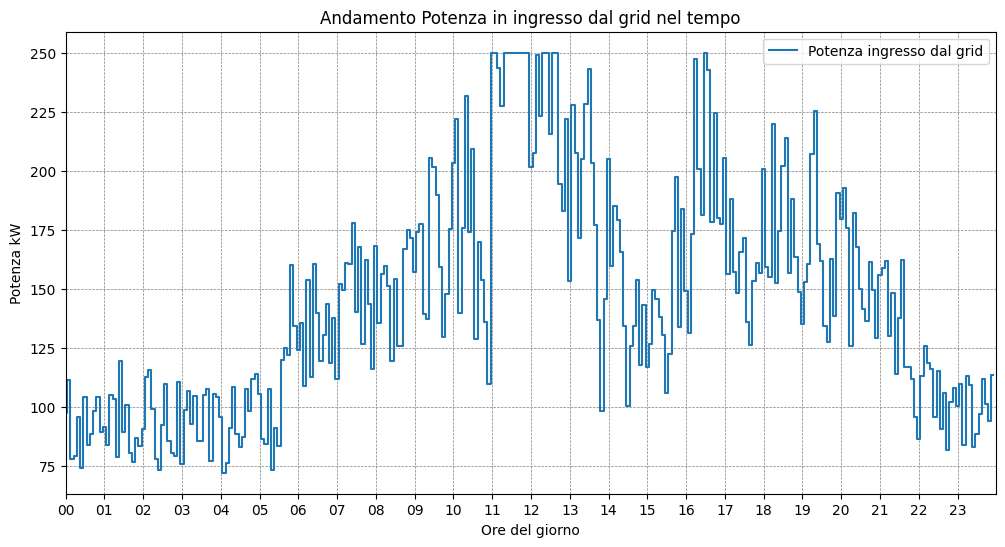

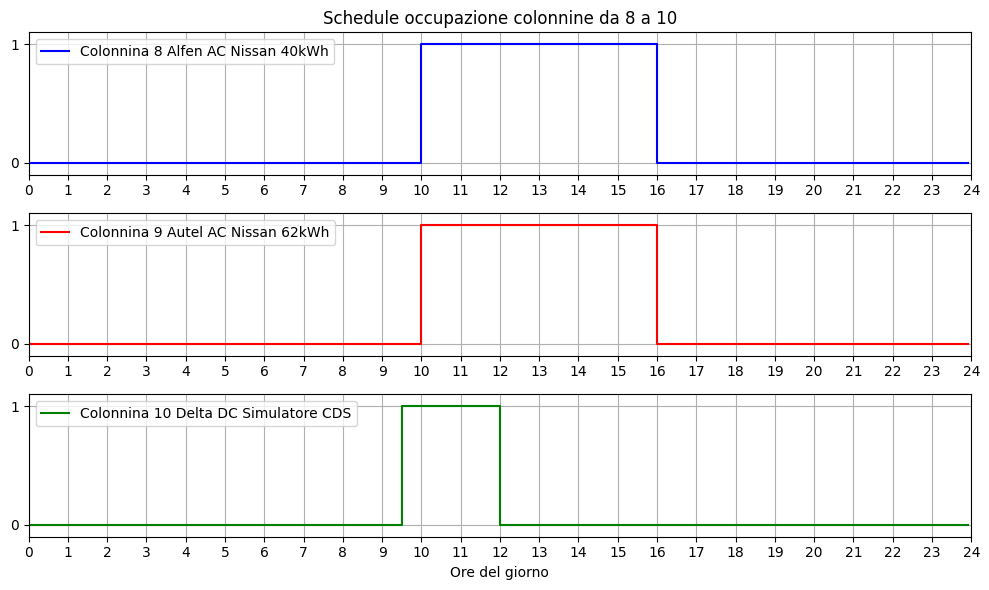

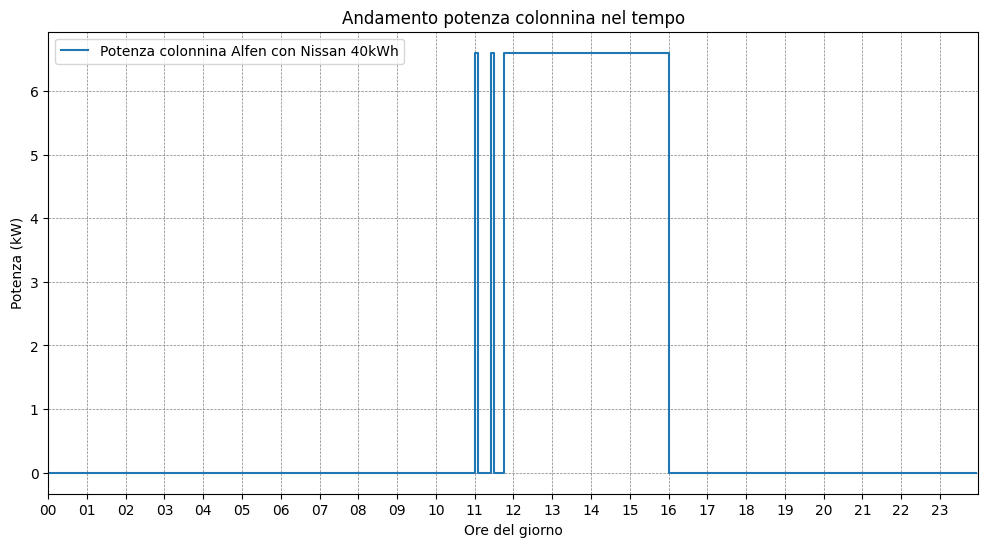

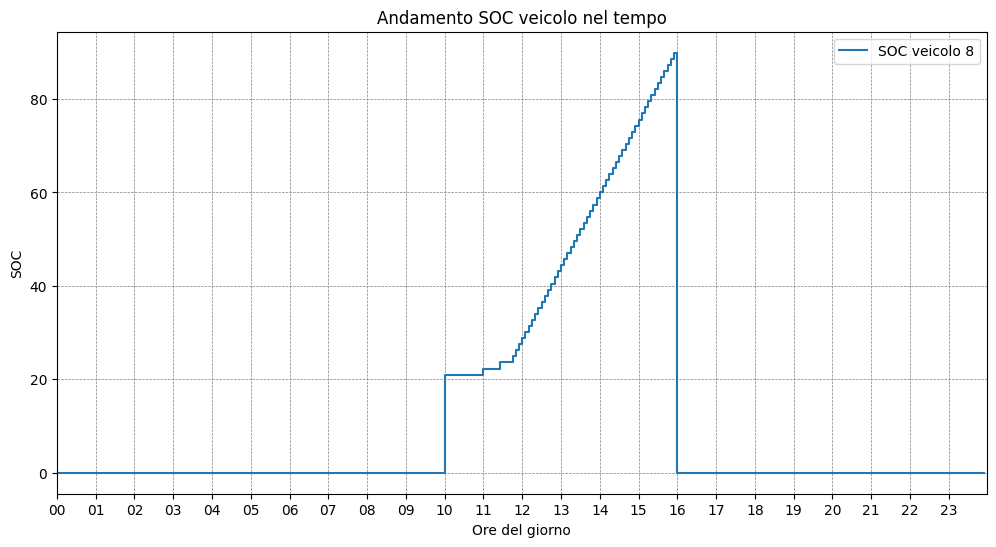

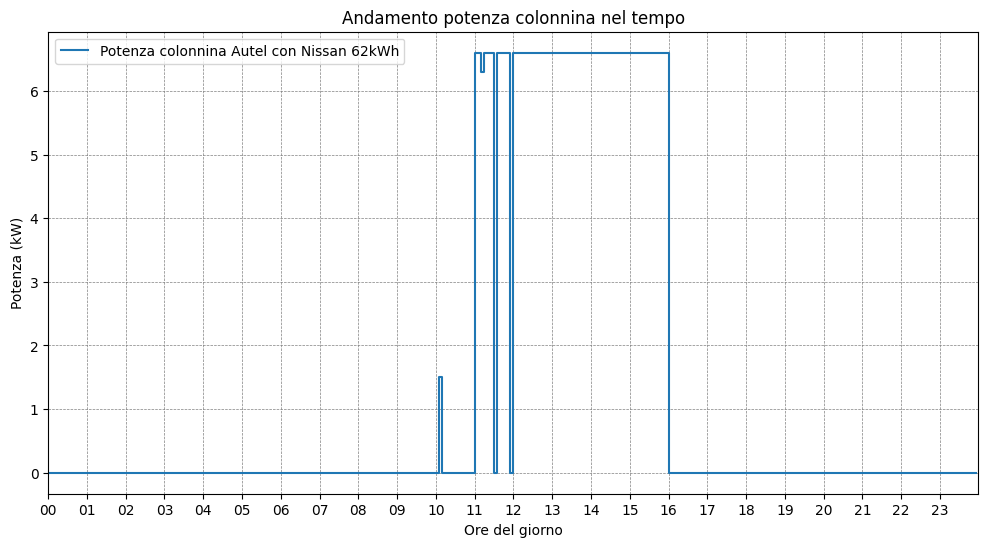

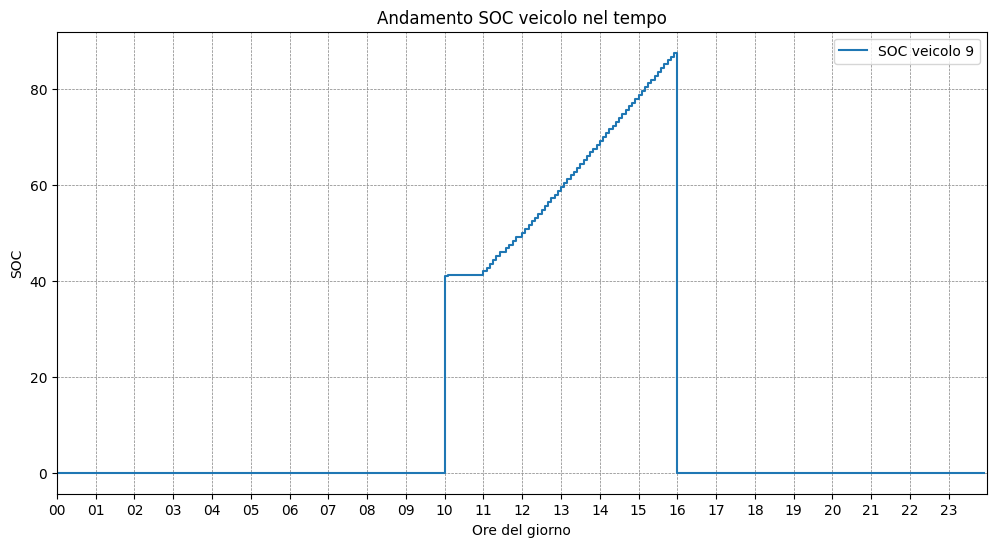

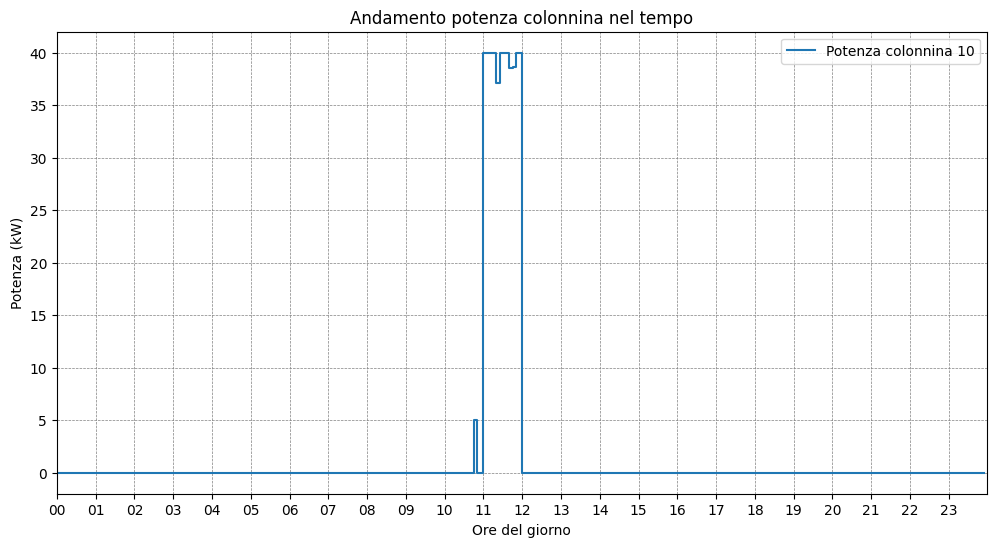

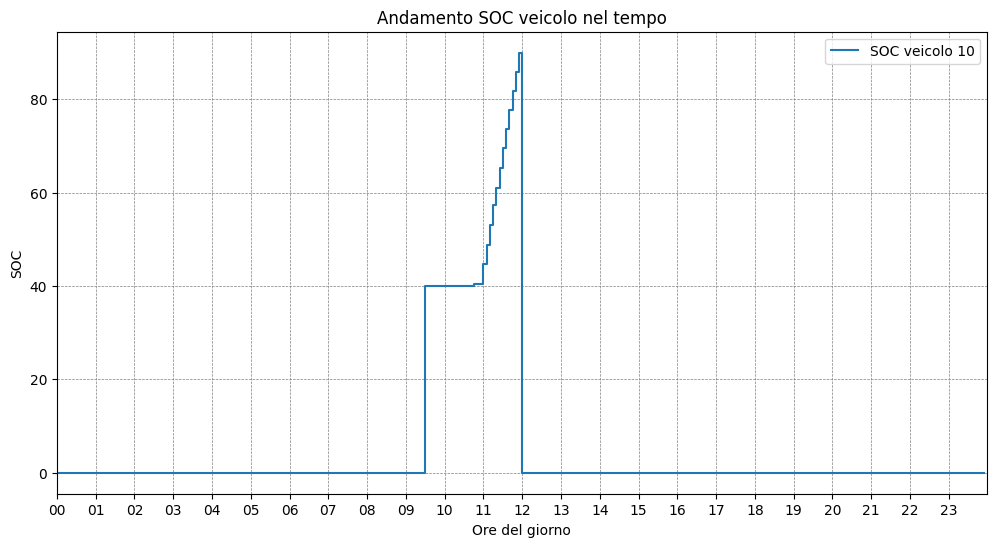

In [12]:
#Grafici Output

#Grafico Potenza assorbita dal grid
plt.figure(figsize=(12, 6))
plt.step(hours_in_day, P_grid_in, label=f"Potenza ingresso dal grid", where='mid')
plt.xlabel("Ore del giorno")
plt.ylabel("Potenza kW")
plt.title("Andamento Potenza in ingresso dal grid nel tempo")
start_time = datetime(2024, 11, 25, 0, 0)
end_time = datetime(2024, 11, 25, 23, 59)
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.xlim(start_time, end_time)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

#Stampa le schedule
def plot_schedule(schedules, num_stations=12):
    """
    Plot the schedules of multiple charging stations.

    Parameters:
    - schedules: numpy array with connection schedules
    - num_stations: number of charging stations (default: 12)
    """
    fig, axs = plt.subplots(3, 1, figsize=(10, 6))
    hours_in_day = np.array([t * init_val['timestamp'] / 60 for t in range(nTimeStamp)])
    etichetta=['Colonnina 8 Alfen AC Nissan 40kWh', 'Colonnina 9 Autel AC Nissan 62kWh', 'Colonnina 10 Delta DC Simulatore CDS']
    colore=['blue', 'red', 'green']

    for i in range(3):
        axs[i].step(hours_in_day, schedules[i+8], label=etichetta[i], color=colore[i], where='post')
        # plt.xticks(x_ticks)  # Mostra i ticks per ogni ora
        # plt.xlim(0, 24)  # Limita l'asse x tra 0 e 24 ore
        axs[i].set_xlim(0, 24)
        axs[i].set_xticks(np.arange(0, 25, 1))
        #axs[i].set_ylabel(f'Colonnina {i+8}')
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_yticks([0, 1])
        axs[i].grid(True)
        axs[i].legend(loc='upper left')

    axs[0].set_title('Schedule occupazione colonnine da 8 a 10')
    axs[-1].set_xlabel('Ore del giorno')
    plt.tight_layout()
    plt.show()

def create_schedule(connection_times, disconnection_times, num_stations=init_val['numChargers'], intervals_per_day=int((60/init_val['timestamp'])*24)):
    """
    Crea la schedule di connessione/disconnessione per le colonnine.
    
    Parameters:
    - connection_times: lista di liste di tuple (ora, minuto) per la connessione
    - disconnection_times: lista di liste di tuple (ora, minuto) per la disconnessione
    - num_stations: numero di colonnine
    - intervals_per_day: numero di intervalli di 5 minuti in un giorno (288)
    
    Returns:
    - schedules: array numpy di shape (num_stations, intervals_per_day) con i flag di connessione
    """
    schedules = np.zeros((num_stations, intervals_per_day), dtype=int)
    
    for i in range(num_stations):
        for conn, disc in zip(connection_times[i], disconnection_times[i]):
            conn_index = time_to_index(*conn)
            disc_index = time_to_index(*disc)
            if conn_index < disc_index:
                schedules[i, conn_index:disc_index] = 1
            else:  # gestione di connessione durante la notte (es. dalle 23:00 alle 02:00)
                schedules[i, conn_index:] = 1
                schedules[i, :disc_index] = 1
    
    return schedules

def time_to_index(hour, minute):
    """Converte un orario (ora, minuto) in un indice del vettore (5 minuti)"""
    return (hour * 60 + minute) // init_val['timestamp']

#Legge il file schedule.csv e crea le liste connection times e disconnection times
connection_times = [None] * nWB
disconnection_times = [None] * nWB

df = pd.read_csv('schedule.csv', header=0)
Connessione1 = df['Connessione1'].tolist()
Disconnessione1 = df['Disconnessione1'].tolist()
Connessione2 = df['Connessione2'].tolist()
Disconnessione2 = df['Disconnessione2'].tolist()

for c in range(nWB):
    connection_times[c] = [(int(Connessione1[c].split(":")[0]), int(Connessione1[c].split(":")[1]))]
    if isinstance(Connessione2[c], str):
        connection_times[c].append((int(Connessione2[c].split(":")[0]), int(Connessione2[c].split(":")[1])))

for c in range(nWB):
    disconnection_times[c] = [(int(Disconnessione1[c].split(":")[0]), int(Disconnessione1[c].split(":")[1]))]
    if isinstance(Disconnessione2[c], str):
        disconnection_times[c].append((int(Disconnessione2[c].split(":")[0]), int(Disconnessione2[c].split(":")[1])))

schedule = create_schedule(connection_times, disconnection_times)
plot_schedule(schedule)


#Grafico pG2V della stazione n
n=8 #Alfen con Nissan 40kWh
plt.figure(figsize=(12, 6))
plt.step(hours_in_day, Potenza_G2V[n], label=f"Potenza colonnina Alfen con Nissan 40kWh", where='post')
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.xlim(start_time, end_time)
plt.xlabel("Ore del giorno")
plt.ylabel("Potenza (kW)")
plt.title("Andamento potenza colonnina nel tempo")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()
# # Grafico SOC della stazione n
plt.figure(figsize=(12, 6))
plt.step(hours_in_day, SOC_veicoli[n], label=f"SOC veicolo {n}", where='post')
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.xlim(start_time, end_time)
plt.xlabel("Ore del giorno")
plt.ylabel("SOC")
plt.title("Andamento SOC veicolo nel tempo")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

#Grafico pG2V della stazione n
n=9  #Autel con Nissan 62kWh
plt.figure(figsize=(12, 6))
plt.step(hours_in_day, Potenza_G2V[n], label=f"Potenza colonnina Autel con Nissan 62kWh", where='post')
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.xlim(start_time, end_time)
plt.xlabel("Ore del giorno")
plt.ylabel("Potenza (kW)")
plt.title("Andamento potenza colonnina nel tempo")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()
#Grafico SOC della stazione n
plt.figure(figsize=(12, 6))
plt.step(hours_in_day, SOC_veicoli[n], label=f"SOC veicolo {n}", where='post')
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.xlim(start_time, end_time)
plt.xlabel("Ore del giorno")
plt.ylabel("SOC")
plt.title("Andamento SOC veicolo nel tempo")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

#Grafico pG2V della stazione n
n=10
plt.figure(figsize=(12, 6))
plt.step(hours_in_day, Potenza_G2V[n], label=f"Potenza colonnina {n}", where='post')
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.xlim(start_time, end_time)
plt.xlabel("Ore del giorno")
plt.ylabel("Potenza (kW)")
plt.title("Andamento potenza colonnina nel tempo")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()
#Grafico SOC della stazione n
plt.figure(figsize=(12, 6))
plt.step(hours_in_day, SOC_veicoli[n], label=f"SOC veicolo {n}", where='post')
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.xlim(start_time, end_time)
plt.xlabel("Ore del giorno")
plt.ylabel("SOC")
plt.title("Andamento SOC veicolo nel tempo")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

#Stampa i grafici di tutte e 12 le colonnine
# for n in range(nWB):
#     plt.figure(figsize=(10, 4))
#     plt.step(hours_in_day, Potenza_G2V[n], label=f"Potenza colonnina {n}", where='post')
#     plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0]))
#     plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
#     plt.xlim(start_time, end_time)
#     plt.xlabel("Ore del giorno")
#     plt.ylabel("Potenza (kW)")
#     plt.title("Andamento potenza colonnina nel tempo")
#     plt.legend()
#     plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
#     plt.show()


In [ ]:
#SOC finali Nissan 40kWh 94%.  Nissan 62kWh 92%

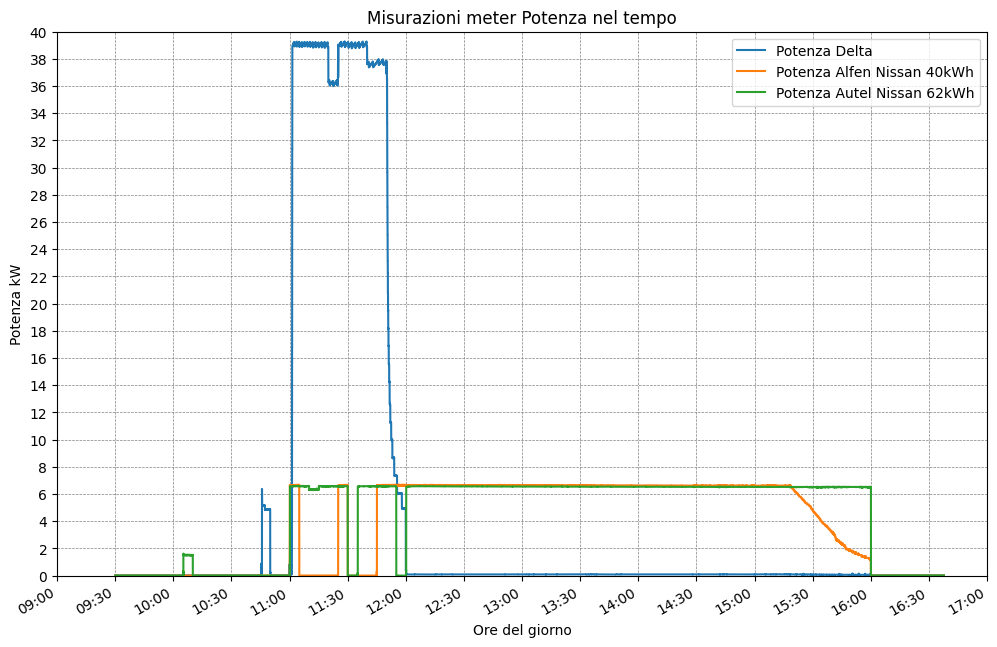

In [3]:
#Visualizzazione letture meter
granularity=1 #s. Sono i secondi di lettura dei meter.
Misure_Alfen=[]
Misure_Autel=[]
Misure_Totali=[]
tempo=[]
with open('M_Alfen.csv', 'r') as file:
    lettore_csv = csv.reader(file)
    for riga in lettore_csv:
        Misure_Alfen.append(float(riga[13]))  #questa è solo la potenza della fase 1

with open('M_Autel.csv', 'r') as file:
    lettore_csv = csv.reader(file)
    for riga in lettore_csv:
        Misure_Autel.append(float(riga[13]))  #questa è solo la potenza della fase 1

with open('M_C.csv', 'r') as file:
    lettore_csv = csv.reader(file)
    for riga in lettore_csv:
        Misure_Totali.append(float(riga[13])+float(riga[14])+float(riga[15]))  #essendo trifase sommo la potenza delle 3 fasi
        tempo.append(datetime.fromisoformat(riga[0]))
        

Misure_Alfen=np.array(Misure_Alfen)
Misure_Autel=np.array(Misure_Autel)
Misure_Totali=np.array(Misure_Totali)
Misure_Delta=(Misure_Totali-Misure_Alfen)-Misure_Autel

Misure_Delta[5066]=Misure_Delta[5065]
#print(np.where(Misure_Delta>40000))

# Grafico Potenza assorbita dalle colonnine
plt.figure(figsize=(12, 8))
plt.step(tempo, Misure_Delta/1000, label=f"Potenza Delta", where='mid')
plt.step(tempo, Misure_Alfen/1000, label=f"Potenza Alfen Nissan 40kWh", where='mid')
plt.step(tempo, Misure_Autel/1000, label=f"Potenza Autel Nissan 62kWh", where='mid')
start_time = datetime(2024, 11, 25, 9, 0)  # Mezzanotte
end_time = datetime(2024, 11, 25, 17, 00)  # Fine della giornata
plt.xlim(start_time, end_time)
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 30]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gcf().autofmt_xdate()  #ruota un po le date
plt.xlabel("Ore del giorno")
plt.ylabel("Potenza kW")
plt.title("Misurazioni meter Potenza nel tempo")
plt.yticks(np.arange(0, 42, 2))
plt.ylim(0, 40)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()


C:\Users\brunet1f\AppData\Local\Temp\ipykernel_13848\336861184.py:30: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(str(init_val['timestamp'])+'T').mean()
C:\Users\brunet1f\AppData\Local\Temp\ipykernel_13848\3032348298.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap_blue = cm.get_cmap('Blues', 5)
C:\Users\brunet1f\AppData\Local\Temp\ipykernel_13848\3032348298.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap_red = cm.get_cmap('Reds', 5)


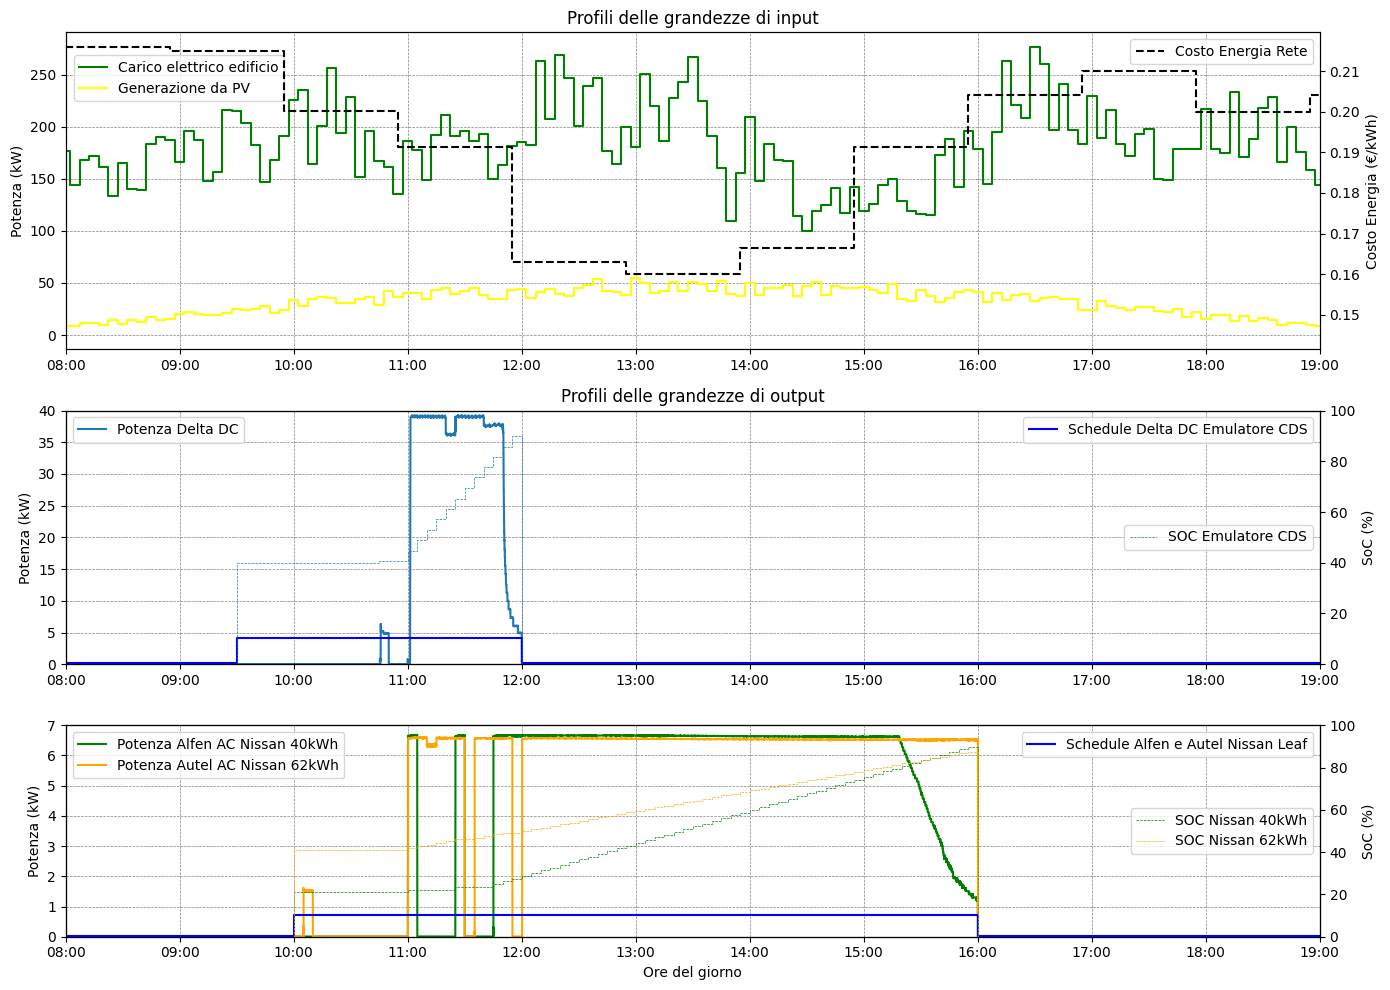

In [4]:
################ GRAFICI DI CONFRONTO#################
buildingLoadScaling= 378*0.95  #kW
power_consumption=process_building_load(buildingLoadScaling)   #importo il profilo di carico giornaliero dell'edificio [kW]
power_pv=process_pv_production()   #importo il profilo di produzione giornaliero da pv [kW]
#creazione del vettore di errore per building load e pv
error_p_c = []
error_pv = []
np.random.seed(42) #fisso il seme di generazione dei numeri casuali in modo da avere sempre lo stesso risultato se ripeto il test. Per avere ogni volta valori diversi togliere questa riga
for _ in range(nTimeStamp):
    error_p_c.append(np.random.uniform(0.8, 1.2))  #crea un vettore di nTimeStamp elementi dove per ogni timestamp è indicato quanto si discosta dall'originale
    error_pv.append(np.random.uniform(0.8, 1.2))

p_c_error=power_consumption * error_p_c
pv_error = power_pv * error_pv

Potenza_Delta=Misure_Delta

# Colormap: scegli una scala di colori (Blues)
colormap_blue = cm.get_cmap('Blues', 5)
colormap_red = cm.get_cmap('Reds', 5)

# Imposta il layout con 3 sottografici
fig, axs = plt.subplots(3, 1, figsize=(14, 10),
                        gridspec_kw={'height_ratios': [1.5, 1.2, 1]}) 

# Primo sottografico
ax1 = axs[0]
ax1.step(hours_in_day, p_c_error, label="Carico elettrico edificio", where='mid', color='green')
ax1.step(hours_in_day, pv_error, label="Generazione da PV", where='mid', color='yellow')
start_time = datetime(2024, 11, 25, 8, 0)
end_time = datetime(2024, 11, 25, 19, 0)
ax1.set_ylabel("Potenza (kW)")
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
ax1.set_xlim(start_time, end_time)
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0]))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_title("Profili delle grandezze di input")
# Secondo asse verticale per il primo sottografico
ax1_2 = ax1.twinx()
ax1_2.step(hours_in_day, costi_in / timeStamp, label="Costo Energia Rete", linestyle="--", color='black')
ax1_2.set_ylabel("Costo Energia (€/kWh)")


# Secondo sottografico
ax2 = axs[1]
ax2.step(tempo, Misure_Delta/1000, label="Potenza Delta DC", where='mid')
ax2.set_ylabel("Potenza (kW)")
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
ax2.set_xlim(start_time, end_time)
ax2.set_title("Profili delle grandezze di output")
ax2.set_yticks(np.arange(0, 41, 5))
ax2.set_ylim(0, 40)
ax2.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0]))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Aggiungi il secondo asse verticale
ax2_1 = ax2.twinx()
ax2_1.step(hours_in_day, schedule[10], label="Schedule Delta DC Emulatore CDS", color='blue', where='post')
ax2_1.set_yticks([0, 10])
ax2_1.yaxis.set_visible(False)
# Aggiungi il terzo asse verticale
ax2_2 = ax2.twinx()
ax2_2.step(hours_in_day, SOC_veicoli[10], label="SOC Emulatore CDS", where='post', linestyle='--', linewidth=0.5)
ax2_2.set_ylabel("SoC (%)")
ax2_2.set_ylim([0, 100])


# Terzo sottografico
ax3 = axs[2]
ax3.step(tempo, Misure_Alfen/1000, label="Potenza Alfen AC Nissan 40kWh", where='mid', color='green')
ax3.step(tempo, Misure_Autel/1000, label="Potenza Autel AC Nissan 62kWh", where='mid', color='orange')
ax3.set_ylabel("Potenza (kW)")
ax3.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
ax3.set_xlim(start_time, end_time)
#ax3.set_title("Misurazioni meter Potenza nel tempo")
ax3.set_yticks(np.arange(0, 8, 1))
ax3.set_ylim(0, 7)
ax3.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0]))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax3.set_xlabel('Ore del giorno')
# Aggiungi il secondo asse verticale
ax3_1 = ax3.twinx()
ax3_1.step(hours_in_day, schedule[8], label="Schedule Alfen e Autel Nissan Leaf", color='blue', where='post')
ax3_1.set_yticks([0, 10])
ax3_1.yaxis.set_visible(False)
# Aggiungi il terzo asse verticale
ax3_2 = ax3.twinx()
ax3_2.step(hours_in_day, SOC_veicoli[8], label="SOC Nissan 40kWh", color='green', where='post', linestyle='--', linewidth=0.5)
ax3_2.step(hours_in_day, SOC_veicoli[9], label="SOC Nissan 62kWh", color='orange', where='post', linestyle='--', linewidth=0.5)
ax3_2.set_ylabel("SoC (%)")
ax3_2.set_ylim([0, 100])

# Aggiungi le legende per ciascun asse
ax1.legend(loc='upper left', bbox_to_anchor=(0.001, 0.95))
ax1_2.legend(loc='upper right')
#ax1_3.legend(loc='center right')  #bbox_to_anchor=(1, 0.93)
ax2.legend(loc='upper left')
ax2_1.legend(loc='upper right')
ax2_2.legend(loc='center right')
ax3.legend(loc='upper left')
ax3_1.legend(loc='upper right')
ax3_2.legend(loc='center right')

# Mostra il grafico
plt.tight_layout()
plt.show()
